In [ ]:
!pip install piml

# Data Pipeline

In [3]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data='SimuCredit')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,Mortgage,Balance,Amount Past Due,Credit Inquiry,Open Trade,Delinquency,Utilization,Gender,Race,Approved
0,196153.90,2115.19,0.00,0.0,0.0,0.0,0.759069,1.0,0.0,1.0
1,149717.49,2713.77,1460.57,1.0,1.0,1.0,0.402820,1.0,0.0,1.0
2,292626.34,2209.01,0.00,0.0,0.0,0.0,0.684272,1.0,1.0,1.0
3,264812.52,21.68,0.00,0.0,0.0,0.0,0.037982,0.0,0.0,0.0
4,236374.39,1421.49,1290.85,0.0,0.0,2.0,0.231110,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
19995,236123.54,3572.34,0.00,0.0,0.0,0.0,0.896326,1.0,1.0,0.0
19996,374572.72,3560.24,0.00,0.0,0.0,0.0,0.648893,1.0,1.0,0.0
19997,279238.55,101.75,0.00,0.0,0.0,0.0,0.068079,0.0,1.0,0.0
19998,149678.27,439.46,214.36,1.0,0.0,2.0,0.311219,0.0,0.0,1.0


In [4]:
# Exclude ['Gender', 'Race']
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [6]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [7]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Model Pipeline

In [8]:
from xgboost import XGBClassifier
XGB5 = XGBClassifier(max_depth=5, n_estimators=500)
exp.model_train(model = XGB5, name='XGB5')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [9]:
from sklearn.neural_network import MLPClassifier
ReLUDNN = MLPClassifier(hidden_layer_sizes=[20]*2, activation="relu",
                        random_state=0)
exp.model_train(model = ReLUDNN, name='ReLUDNN')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

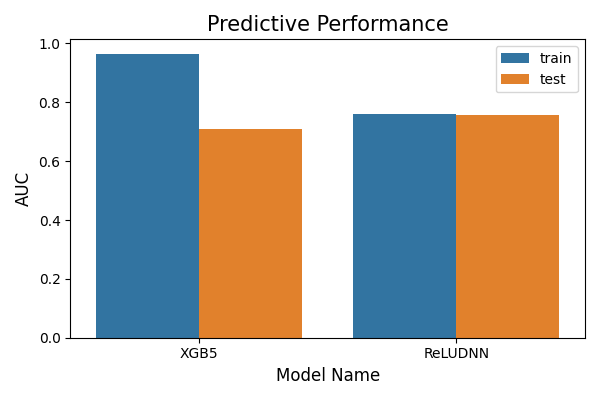

In [10]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="accuracy_plot",
                  metric="AUC", figsize=(6, 4))

# Model Diagnostics

## Error Analysis

- Assess models as usual by accuracy and residuals
- Apply error slicing to identify regions with underfitting/overfitting weakness

In [11]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

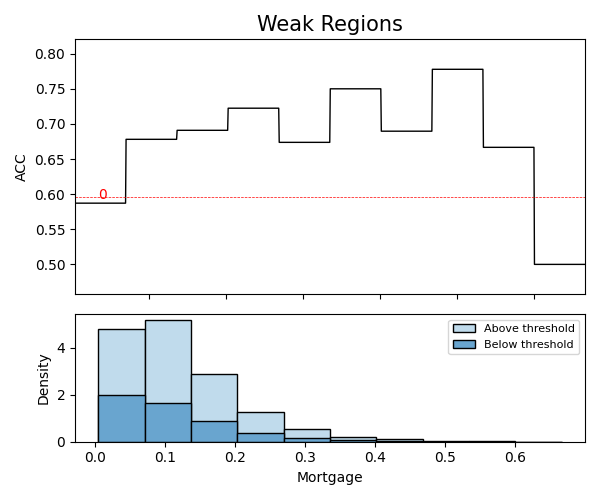

In [13]:
exp.model_diagnose(model="XGB5", show="weakspot", metric="ACC",
                   slice_method="histogram", slice_features=["Mortgage"],
                   threshold=1.1, min_samples=20, use_test=True, figsize=(6, 5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

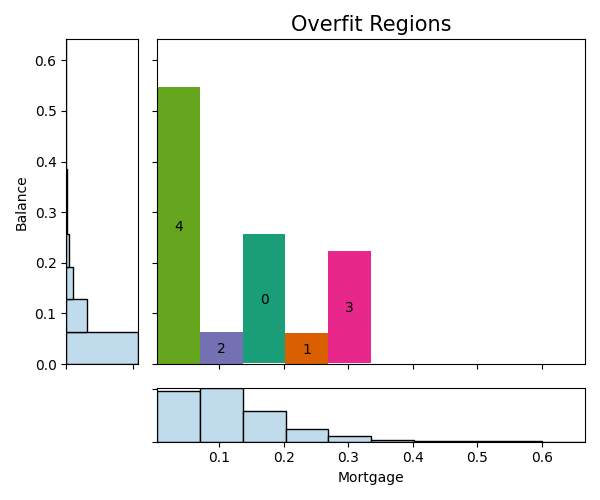

In [15]:
exp.model_diagnose(model="XGB5", show="overfit", metric="ACC",
                   slice_method="histogram", slice_features=["Mortgage", "Balance"],
                   threshold=1.2, min_samples=100, figsize=(6, 5))

## Resilience Test

- Run exp.model_diagnose() choose "Resilience" Tab
- Choose resilient scenarios: worst-sample, worst-cluster
- Measure distribution drift by PSI
- Verify sensitive/vulnerable variables by WeakSpot

In [12]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Segmented Diagnostics

- Data clustering through K-Means
- Demo use of PiML scored_test APIs for check performance heterogeneity

In [42]:
from sklearn.cluster import KMeans
x, y, _ = exp.get_data()
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)
segmodel = KMeans(n_clusters=5, random_state=0)
segmodel.fit(train_x)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

KMeans(n_clusters=5, random_state=0)

In [ ]:
# Wrap segmented scored data
TargetModel = 'XGB5'
train_idx, test_idx = exp.get_model(TargetModel).get_train_test_idx()
prediction = exp.get_model(model=TargetModel).estimator.predict(x)
prediction_proba = exp.get_model(model=TargetModel).estimator.predict_proba(x)[:, -1]

trainx_seg_idx = segmodel.predict(train_x)
testx_seg_idx = segmodel.predict(test_x)

seg_scored_data = {}
for SegID in range(segmodel.n_clusters):
    scored_data = {'x': x,
                        'y': y,
                        'prediction': prediction,
                        'prediction_proba': prediction_proba,
                        'train_idx': train_idx[trainx_seg_idx == SegID],
                        'test_idx': test_idx[testx_seg_idx == SegID],
                        'feature_names': exp.get_feature_names(),
                        'feature_types': exp.get_feature_types()}
    seg_scored_data[SegID] = scored_data

In [45]:
from piml.scored_test import test_accuracy, residual_plot, slicing_weakspot
import ipywidgets as widgets
import pandas as pd

test_auc_list = []
for SegID in range(segmodel.n_clusters):
    with widgets.Output():
      res = test_accuracy(**seg_scored_data[SegID])[0]
      test_auc_list.append(res['ACC'][1])
pd.DataFrame(test_auc_list, columns =['ACC'], dtype = float)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC
0,0.6415
1,0.6612
2,0.6114
3,0.6621
4,0.8441


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

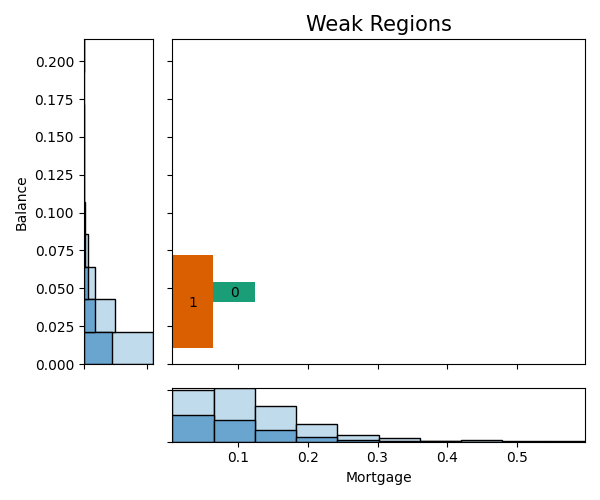

In [46]:
SegID = 2
res = slicing_weakspot(**seg_scored_data[SegID], slice_features=['Mortgage','Balance'],
                       threshold=1.2, slice_method="histogram",
                       min_samples=20, figsize=(6, 5))